In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]})
}

# 倍数范围
multipliers = [1, 2, 3]  # 可以调整倍数的范围
best_multiplier = None
best_score = 0
results_summary = {}

# 尝试不同倍数的负样本选择
for multiplier in multipliers:
    print(f"Testing multiplier: {multiplier}")
    results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': []} for model in models_params}

    # 进行5折交叉验证
    for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
        positive_train = positive_samples.iloc[train_index]
        positive_test = positive_samples.iloc[test_index]
        
        # 分离负样本
        negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
        
        # 对训练集负样本进行聚类选择
        num_clusters_train = multiplier * len(positive_train)
        num_clusters_train = min(num_clusters_train, len(negative_train))  # 防止聚类数超过样本数
        if num_clusters_train < 1:
            num_clusters_train = 1
        kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=42)
        negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
        kmeans_train.fit(negative_train_fingerprints)
        closest_train, _ = pairwise_distances_argmin_min(kmeans_train.cluster_centers_, negative_train_fingerprints)
        selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]
        
        # 对测试集负样本进行聚类选择
        num_clusters_test = multiplier * len(positive_test)
        num_clusters_test = min(num_clusters_test, len(negative_test))  # 防止聚类数超过样本数
        if num_clusters_test < 1:
            num_clusters_test = 1
        kmeans_test = KMeans(n_clusters=num_clusters_test, random_state=42)
        negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
        kmeans_test.fit(negative_test_fingerprints)
        closest_test, _ = pairwise_distances_argmin_min(kmeans_test.cluster_centers_, negative_test_fingerprints)
        selected_negative_test = negative_test.iloc[closest_test[:num_clusters_test]]
        
        # 合并训练和测试数据集
        train_data = pd.concat([positive_train, selected_negative_train])
        test_data = pd.concat([positive_test, selected_negative_test])
        
        # 准备训练和测试数据
        X_train = np.vstack(train_data['fingerprint'].values)
        y_train = train_data['antibiotic_activity'].values
        X_test = np.vstack(test_data['fingerprint'].values)
        y_test = test_data['antibiotic_activity'].values
        
        # 特征缩放
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 对每个模型进行训练和评估
        for model_name, (model, params) in models_params.items():
            clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
            clf.fit(X_train_scaled, y_train)
            best_model = clf.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
            if hasattr(best_model, "predict_proba"):
                y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            else:
                # 对于不支持 predict_proba 的模型，如某些 SVM
                y_pred_proba = best_model.decision_function(X_test_scaled)
                y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())  # 归一化到 [0,1]
            
            # 计算性能指标
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            prc_auc = auc(recall, precision)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            
            # 存储结果
            results[model_name]['ROC-AUC'].append(roc_auc)
            results[model_name]['PRC-AUC'].append(prc_auc)
            results[model_name]['Accuracy'].append(accuracy)
            results[model_name]['F1 Score'].append(f1)
            results[model_name]['MCC'].append(mcc)

    # 计算均值和标准差
    mean_std_results = {model: {metric: (np.mean(scores), np.std(scores)) 
                                for metric, scores in metrics.items()} 
                        for model, metrics in results.items()}

    # 存储当前倍数的结果
    results_summary[multiplier] = mean_std_results

    # 选择最佳倍数（这里仍以 ROC-AUC 为准，可以根据需要调整）
    avg_score = np.mean([mean_std_results[model]['ROC-AUC'][0] for model in mean_std_results])
    if avg_score > best_score:
        best_score = avg_score
        best_multiplier = multiplier

print(f"Best multiplier: {best_multiplier} with average ROC-AUC score: {best_score}")

# 可视化不同倍数的性能指标
metrics_to_plot = ['ROC-AUC', 'PRC-AUC', 'Accuracy', 'F1 Score', 'MCC']
fig, ax = plt.subplots(figsize=(14, 10))

bar_width = 0.15
indices = np.arange(len(multipliers) * len(models_params))
colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_to_plot)))

for i, metric in enumerate(metrics_to_plot):
    means = []
    stds = []
    labels = []
    for multiplier in multipliers:
        for model in models_params:
            means.append(results_summary[multiplier][model][metric][0])
            stds.append(results_summary[multiplier][model][metric][1])
            labels.append(f"{model} (x{multiplier})")
    ax.barh(np.arange(len(means)) + i * bar_width, means, bar_width, xerr=stds, 
            color=colors[i], alpha=0.7, label=metric)

ax.set_yticks(np.arange(len(means)) + bar_width * (len(metrics_to_plot)-1) / 2)
ax.set_yticklabels(labels)
plt.title('Model Performance with Different Negative Sample Multipliers')
plt.xlabel('Score')
plt.ylabel('Model and Multiplier')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Testing multiplier: 1


: 

In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [], 
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行聚类选择
    num_clusters_train = 2 * len(positive_train)
    num_clusters_train = min(num_clusters_train, len(negative_train))  # 防止聚类数超过样本数
    num_clusters_train = max(num_clusters_train, 1)  # 至少一个簇
    kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=42)
    negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
    kmeans_train.fit(negative_train_fingerprints)
    closest_train, _ = pairwise_distances_argmin_min(kmeans_train.cluster_centers_, negative_train_fingerprints)
    selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]
    
    # 对测试集负样本进行聚类选择
    num_clusters_test = 2 * len(positive_test)
    num_clusters_test = min(num_clusters_test, len(negative_test))  # 防止聚类数超过样本数
    num_clusters_test = max(num_clusters_test, 1)  # 至少一个簇
    kmeans_test = KMeans(n_clusters=num_clusters_test, random_state=42)
    negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
    kmeans_test.fit(negative_test_fingerprints)
    closest_test, _ = pairwise_distances_argmin_min(kmeans_test.cluster_centers_, negative_test_fingerprints)
    selected_negative_test = negative_test.iloc[closest_test[:num_clusters_test]]
    
    # 合并训练和测试数据集
    train_data = pd.concat([positive_train, selected_negative_train])
    test_data = pd.concat([positive_test, selected_negative_test])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall, precision)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_per_fold.csv', index=False)




Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


Model Performance Metrics (Mean ± Std):
                                                        ROC-AUC  \
Logistic Regression  (0.8513467632412854, 0.027429110620771094)   
SVM                    (0.8626358080579447, 0.0381218114601356)   
Random Forest        (0.8820167496604799, 0.028820946546071556)   
Decision Tree          (0.725011317338162, 0.02851788111224288)   
KNN                  (0.7308567224988682, 0.024192571393967882)   
XGBoost               (0.8542100497962879, 0.02404033730117061)   

                                                        PRC-AUC  \
Logistic Regression   (0.7493413389885657, 0.05677713849869851)   
SVM                   (0.7766207780077895, 0.06226534862049942)   
Random Forest        (0.8009111716351548, 0.048333667767208544)   
Decision Tree        (0.6744397130006001, 0.032414551333618646)   
KNN                   (0.7179415318691842, 0.04416001725901889)   
XGBoost                (0.7692943690590115, 0.0449879693998429)   

                    

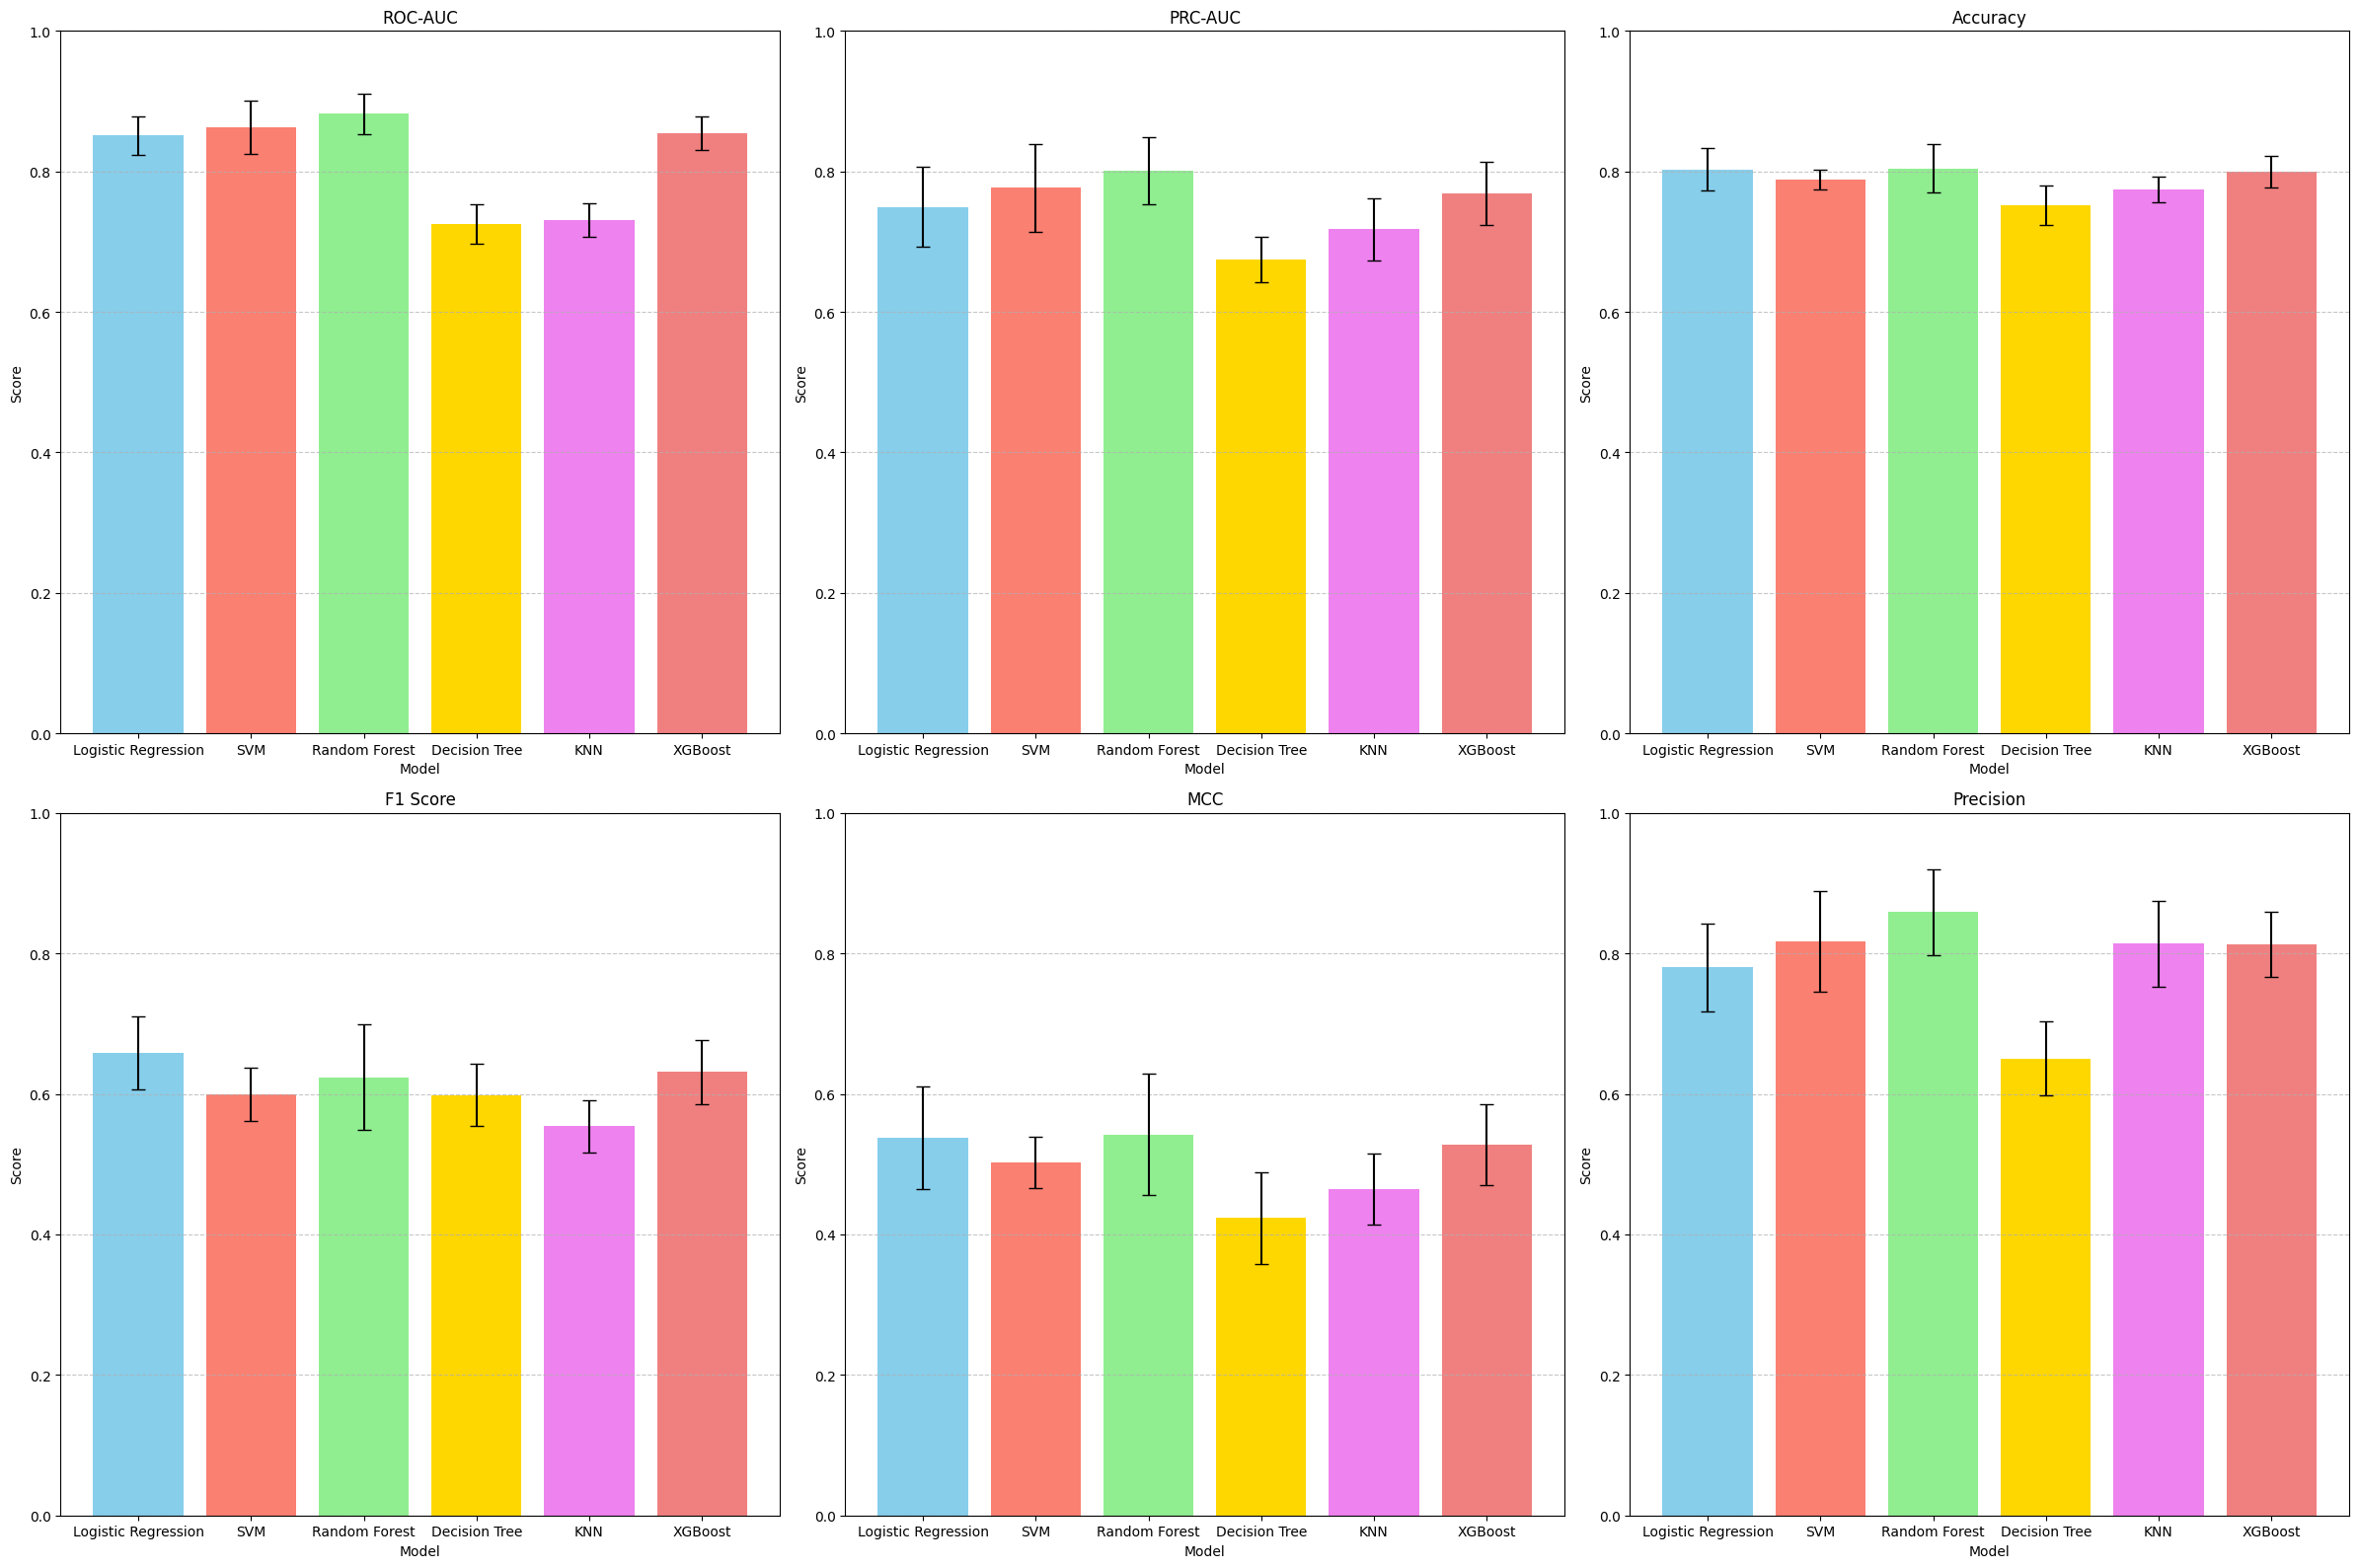

In [10]:
# 计算均值和标准差
mean_std_results = {
    model: {metric: (np.mean(scores), np.std(scores))
            for metric, scores in metrics.items()}
    for model, metrics in results.items()
}

# 打印结果，包括新增的指标
mean_std_df = pd.DataFrame(mean_std_results).T
print("Model Performance Metrics (Mean ± Std):")
print(mean_std_df)

# 绘图，包括新增的指标

metrics_to_plot = ['ROC-AUC', 'PRC-AUC', 'Accuracy', 'F1 Score', 'MCC', 'Precision']
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    means = [mean_std_results[model][metric][0] for model in models_params]
    stds = [mean_std_results[model][metric][1] for model in models_params]
    ax.bar(models_params.keys(), means, yerr=stds, capsize=5, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'violet', 'lightcoral'])
    ax.set_title(f"{metric}")
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    # 针对 False Positive Rate 设置 y 轴范围
    if metric == 'False Positive Rate':
        ax.set_ylim(0, max(means) + max(stds) + 0.05)
    else:
        ax.set_ylim(0, 1)  # 一致的y轴范围，便于比较
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/DuYih/Desktop/antibiotics_performance.pdf')

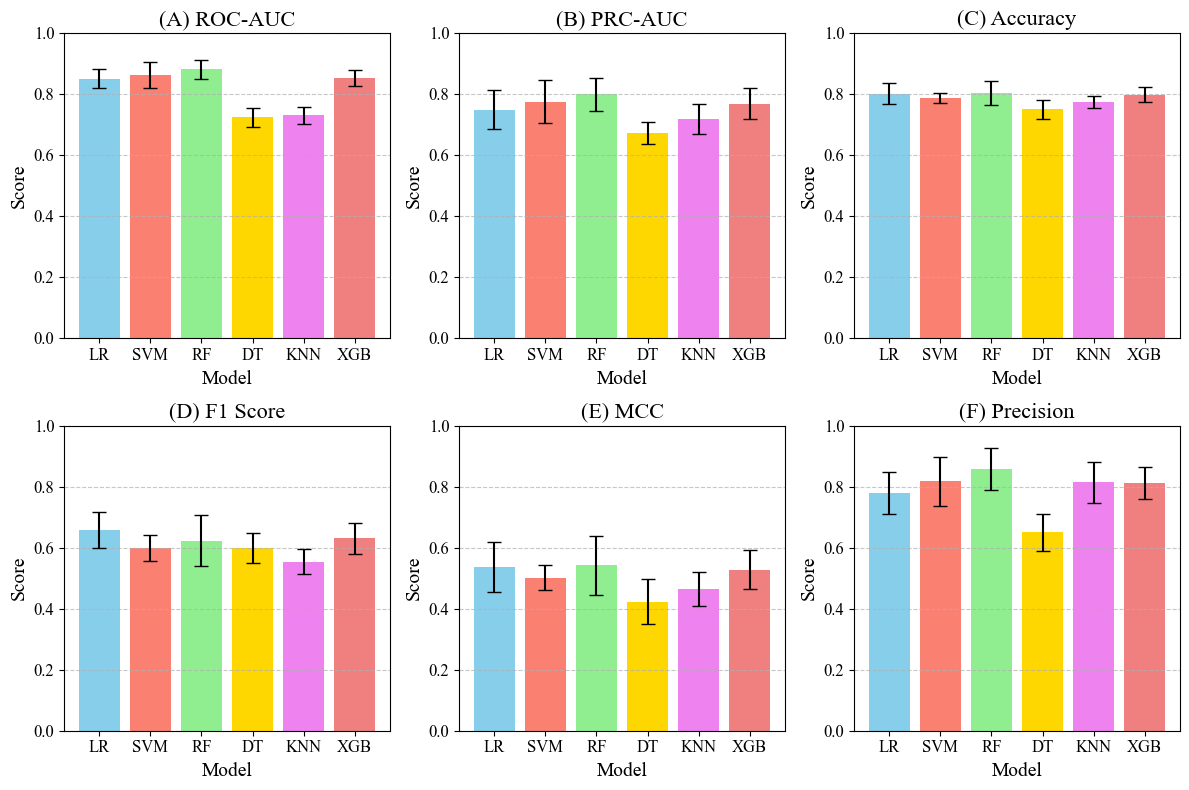

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 设置全局字体为 Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 读取保存的结果文件
fold_results_df = pd.read_csv('model_evaluation_per_fold.csv')

# 要绘制的性能指标
metrics_to_plot = ['ROC-AUC', 'PRC-AUC', 'Accuracy', 'F1 Score', 'MCC', 'Precision']

# 获取所有模型的名称
models = fold_results_df['Model'].unique()

# 创建模型名称与缩写的映射
model_abbr = {
    'Logistic Regression': 'LR',
    'SVM': 'SVM',
    'Random Forest': 'RF',
    'Decision Tree': 'DT',
    'KNN': 'KNN',
    'XGBoost': 'XGB'
}

# 使用缩写后的模型名称列表
models_abbr = [model_abbr[model] for model in models]

# 计算每个模型的均值和标准差
mean_std_results = {}

for model in models:
    model_data = fold_results_df[fold_results_df['Model'] == model]
    mean_std_results[model] = {}
    for metric in metrics_to_plot:
        mean = model_data[metric].mean()
        std = model_data[metric].std()
        mean_std_results[model][metric] = (mean, std)

# 绘制图形
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 调整图形大小
axes = axes.ravel()

# 字母序号列表，用于子图标题
letters = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    means = [mean_std_results[model][metric][0] for model in models]
    stds = [mean_std_results[model][metric][1] for model in models]
    ax.bar(models_abbr, means, yerr=stds, capsize=5, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'violet', 'lightcoral'])
    ax.set_title(f"{letters[i]} {metric}", fontsize=16)
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    # 一致的 y 轴范围，便于比较
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=0, labelsize=12)  # 将 x 轴标签旋转角度设为 0
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
# 显示图形或保存到文件
plt.show()
# plt.savefig('C:/Users/DuYih/Desktop/antibiotics_performance.pdf')


In [2]:
mean_std_results

{'Logistic Regression': {'ROC-AUC': (0.8513467632412854, 0.030666677955202813),
  'PRC-AUC': (0.7493413389885657, 0.06347877062550511),
  'Accuracy': (0.802836879432624, 0.03406840035312185),
  'F1 Score': (0.6583045503587789, 0.05795097392034732),
  'MCC': (0.5377232400557974, 0.08226071706571554),
  'Precision': (0.7805311276835235, 0.06978077312135005)},
 'SVM': {'ROC-AUC': (0.8626358080579447, 0.04262148092514686),
  'PRC-AUC': (0.7766207780077895, 0.06961477607907973),
  'Accuracy': (0.7879432624113475, 0.015739248951185916),
  'F1 Score': (0.5989919928282067, 0.0426046663502079),
  'MCC': (0.5020125737257769, 0.040992110950077446),
  'Precision': (0.8176076436516428, 0.0798347436974357)},
 'Random Forest': {'ROC-AUC': (0.8820167496604799, 0.03222279782645185),
  'PRC-AUC': (0.8009111716351548, 0.05403868336468439),
  'Accuracy': (0.8042553191489361, 0.038634584964439306),
  'F1 Score': (0.6238764441308758, 0.08463156001921977),
  'MCC': (0.5422882809394602, 0.09634763439992816),


In [ ]:
# 不进行欠采样


import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本，保持与正样本相同的分割
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 合并训练和测试数据集，不进行欠采样
    train_data = pd.concat([positive_train, negative_train])
    test_data = pd.concat([positive_test, negative_test])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_no_undersampling.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行随机欠采样，选择正样本2倍的负样本
    num_negative_train_samples = 2 * len(positive_train)
    negative_train_sampled = negative_train.sample(n=min(num_negative_train_samples, len(negative_train)), random_state=fold, replace=False)
    
    # 对测试集负样本进行随机欠采样，选择正样本2倍的负样本
    num_negative_test_samples = 2 * len(positive_test)
    negative_test_sampled = negative_test.sample(n=min(num_negative_test_samples, len(negative_test)), random_state=fold, replace=False)
    
    # 合并训练和测试数据集
    train_data = pd.concat([positive_train, negative_train_sampled])
    test_data = pd.concat([positive_test, negative_test_sampled])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_random_undersampling.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [], 
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行聚类选择
    num_clusters_train = 2 * len(positive_train)
    num_clusters_train = min(num_clusters_train, len(negative_train))  # 防止聚类数超过样本数
    num_clusters_train = max(num_clusters_train, 1)  # 至少一个簇
    kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=42)
    negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
    kmeans_train.fit(negative_train_fingerprints)
    closest_train, _ = pairwise_distances_argmin_min(kmeans_train.cluster_centers_, negative_train_fingerprints)
    selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]
    
    # 合并训练数据集
    train_data = pd.concat([positive_train, selected_negative_train])
    
    # 准备训练数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    
    # 准备测试数据（使用所有测试样本）
    test_data = pd.concat([positive_test, negative_test])
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 计算训练集中负样本到其最近聚类中心的最大距离，作为阈值
    distances_train = np.min(kmeans_train.transform(negative_train_fingerprints), axis=1)
    max_distance_threshold = np.max(distances_train[closest_train])  # 选定的负样本的最大距离

    # 对测试集中负样本进行距离计算，判断是否在阈值范围内
    negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
    distances_test = np.min(kmeans_train.transform(negative_test_fingerprints), axis=1)
    # 标记测试集中负样本是否在阈值范围内
    negative_test_included = distances_test <= max_distance_threshold

    # 创建一个包含样本是否被包含的标记
    test_data = test_data.reset_index(drop=True)
    test_data['Included'] = True  # 默认全部包含
    # 对于测试集中的负样本，更新 'Included' 列
    test_data.loc[test_data['antibiotic_activity'] == 0, 'Included'] = negative_test_included

    # 准备用于评估的测试数据
    X_test_included = X_test_scaled[test_data['Included'].values]
    y_test_included = y_test[test_data['Included'].values]
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        
        # 对所有测试样本进行预测
        y_pred_all = best_model.predict(X_test_scaled)
        if hasattr(best_model, "predict_proba"):
            y_pred_proba_all = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred_proba_all = best_model.decision_function(X_test_scaled)
            y_pred_proba_all = (y_pred_proba_all - y_pred_proba_all.min()) / (y_pred_proba_all.max() - y_pred_proba_all.min()) if y_pred_proba_all.max() != y_pred_proba_all.min() else np.zeros_like(y_pred_proba_all)
        
        # 仅对包含的样本进行评估
        y_pred = y_pred_all[test_data['Included'].values]
        y_pred_proba = y_pred_proba_all[test_data['Included'].values]
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test_included, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test_included, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test_included, y_pred)
        f1 = f1_score(y_test_included, y_pred)
        mcc = matthews_corrcoef(y_test_included, y_pred)
        recall_value = recall_score(y_test_included, y_pred)
        precision_score_value = precision_score(y_test_included, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test_included, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate,
            'Included Samples': len(y_test_included),
            'Total Test Samples': len(y_test)
        }
        all_fold_results.append(fold_result)
    
    # 可选：将每折的测试样本的包含情况保存到文件
    test_data['Predicted'] = y_pred_all
    test_data['Predicted_Probability'] = y_pred_proba_all
    test_data.to_csv(f'test_data_fold_{fold + 1}.csv', index=False)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_filtered_validation.csv', index=False)

# 计算平均结果
average_results = {}
for model_name in models_params.keys():
    average_results[model_name] = {metric: np.mean(values) for metric, values in results[model_name].items()}

# 将平均结果保存为DataFrame
average_results_df = pd.DataFrame(average_results).T.reset_index()
average_results_df.rename(columns={'index': 'Model'}, inplace=True)
average_results_df.to_csv('average_model_evaluation.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 随机选择10000个样本作为测试集
test_data = data.sample(n=10000, random_state=42)
train_data = data.drop(test_data.index)

# 分离训练集中的正负样本
positive_train = train_data[train_data['antibiotic_activity'] == 1]
negative_train = train_data[train_data['antibiotic_activity'] == 0]

# 对训练集负样本进行随机欠采样，选择正样本2倍的负样本
num_negative_train_samples = 2 * len(positive_train)
negative_train_sampled = negative_train.sample(n=min(num_negative_train_samples, len(negative_train)), random_state=42, replace=False)

# 合并训练数据
train_data_balanced = pd.concat([positive_train, negative_train_sampled])

# 准备训练和测试数据
X_train = np.vstack(train_data_balanced['fingerprint'].values)
y_train = train_data_balanced['antibiotic_activity'].values
X_test = np.vstack(test_data['fingerprint'].values)
y_test = test_data['antibiotic_activity'].values

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储结果
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储详细结果
all_results = []

# 对每个模型进行训练和评估
for model_name, (model, params) in models_params.items():
    print(f"训练和评估模型: {model_name}")
    clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
    clf.fit(X_train_scaled, y_train)
    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # 处理预测概率
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        # 对于不支持 predict_proba 的模型，如某些 SVM
        y_pred_proba = best_model.decision_function(X_test_scaled)
        # 将决策函数输出归一化到 [0,1]
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
    
    # 计算性能指标
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall_vals, precision_vals)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    recall_value = recall_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    # 存储结果
    results[model_name]['ROC-AUC'].append(roc_auc)
    results[model_name]['PRC-AUC'].append(prc_auc)
    results[model_name]['Accuracy'].append(accuracy)
    results[model_name]['F1 Score'].append(f1)
    results[model_name]['MCC'].append(mcc)
    results[model_name]['Precision'].append(precision_score_value)
    results[model_name]['Recall'].append(recall_value)
    results[model_name]['False Positives'].append(fp)
    results[model_name]['False Positive Rate'].append(fp_rate)
    
    # 存储每个模型的详细结果
    result = {
        'Model': model_name,
        'ROC-AUC': roc_auc,
        'PRC-AUC': prc_auc,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'MCC': mcc,
        'Recall': recall_value,
        'Precision': precision_score_value,
        'False Positives': fp,
        'False Positive Rate': fp_rate
    }
    all_results.append(result)

# 将结果保存为DataFrame
results_df = pd.DataFrame(all_results)
# 保存到CSV文件
results_df.to_csv('ML_performance/model_evaluation_random_sampling.csv', index=False)


训练和评估模型: Logistic Regression
训练和评估模型: SVM


c:\Users\DuYih\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


训练和评估模型: Random Forest
训练和评估模型: Decision Tree
训练和评估模型: KNN
训练和评估模型: XGBoost
